<a href="https://colab.research.google.com/github/MautKaFarishta/Tweeter_Sentiment_Analysis/blob/main/Tweeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *In this particular Notebook we have scrapped the tweets from #DogeCoinTo1Dollor*

For referance this hashtag was trending on 7th of May after famous Cryptocurrency DogeCoin hit the mark of 0.72$ and investors were exited and expecting to hit the mark of 1 Dollor. We were exited to see what was the sentiment of the users. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re
import nltk
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,accuracy_score,roc_curve,confusion_matrix,f1_score

from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# ***Basic Information***

---



In [2]:
data = pd.read_csv('scraped_tweets.csv')
data.head()

,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,0,emadelia2,NaN,NaN,1928,154,1018,330,BREAKING NEWS !!!\nJeff Bezos private jet land...,"['dogecoin', 'SNL', 'SNLdoge']"
1,1,NIKERED7,SPR7,"Manhattan, NY",9,109,7440,273,"If amazon announces they accept #dogecoin, the...","['dogecoin', 'dogetothemoon']"
2,2,marsudianton,Marketers,Balikpapan_indonesia,436,180,1932,1792,AMAZON JUST PUT A DOGE ON THEIR APP TODAY!\n\n...,['Dogecoin']
3,3,SaulCha02766278,NaN,NaN,12,15,47,1,THIS IS NOT A DRILL HERE WE GO BIG THINGS IN T...,"['dogetothemoon', 'doge', 'dogecoin', 'DogeSNL..."
4,4,khonamiee,NaN,NaN,37,19,81,1418,"Rt, follow me and drop your #dogecoin address ...","['dogecoin', 'dogetothemoon', 'dogearmy', 'Dog..."


In [3]:
data.columns

Index(['Unnamed: 0', 'username', 'description', 'location', 'following',
       'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'],
      dtype='object')

In [4]:
data.info

<bound method DataFrame.info of       Unnamed: 0  ...                                           hashtags
0              0  ...                     ['dogecoin', 'SNL', 'SNLdoge']
1              1  ...                      ['dogecoin', 'dogetothemoon']
2              2  ...                                       ['Dogecoin']
3              3  ...  ['dogetothemoon', 'doge', 'dogecoin', 'DogeSNL...
4              4  ...  ['dogecoin', 'dogetothemoon', 'dogearmy', 'Dog...
...          ...  ...                                                ...
4995        4995  ...                                       ['Dogecoin']
4996        4996  ...                                       ['Dogecoin']
4997        4997  ...                                       ['Dogecoin']
4998        4998  ...                                ['Dogecoin', 'SNL']
4999        4999  ...                                       ['Dogecoin']

[5000 rows x 10 columns]>

In [5]:
len(data['description'].value_counts())

2480

In [6]:
data.drop(['Unnamed: 0'],inplace=True,axis=1)

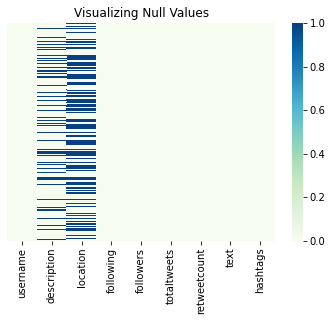

In [7]:
sns.heatmap(data.isnull(), cbar=True, yticklabels=False, cmap="GnBu")
plt.title("Visualizing Null Values")
plt.show()

# *Location EDA*

---



In [8]:
data['location'].unique()

array([nan, 'Manhattan, NY', 'Balikpapan_indonesia', ...,
       'Port Richey, FL', 'Kerala, India', 'Goodings Grove, IL'],
      dtype=object)

In [9]:
len(data['location'].unique())

1249

In [10]:
#Grouping Dataframe By Locations
location_grp=data.groupby(by=['location'])

In [11]:
lob = location_grp['text'].count()

In [12]:
lob_sorted = lob.sort_values(ascending=False)

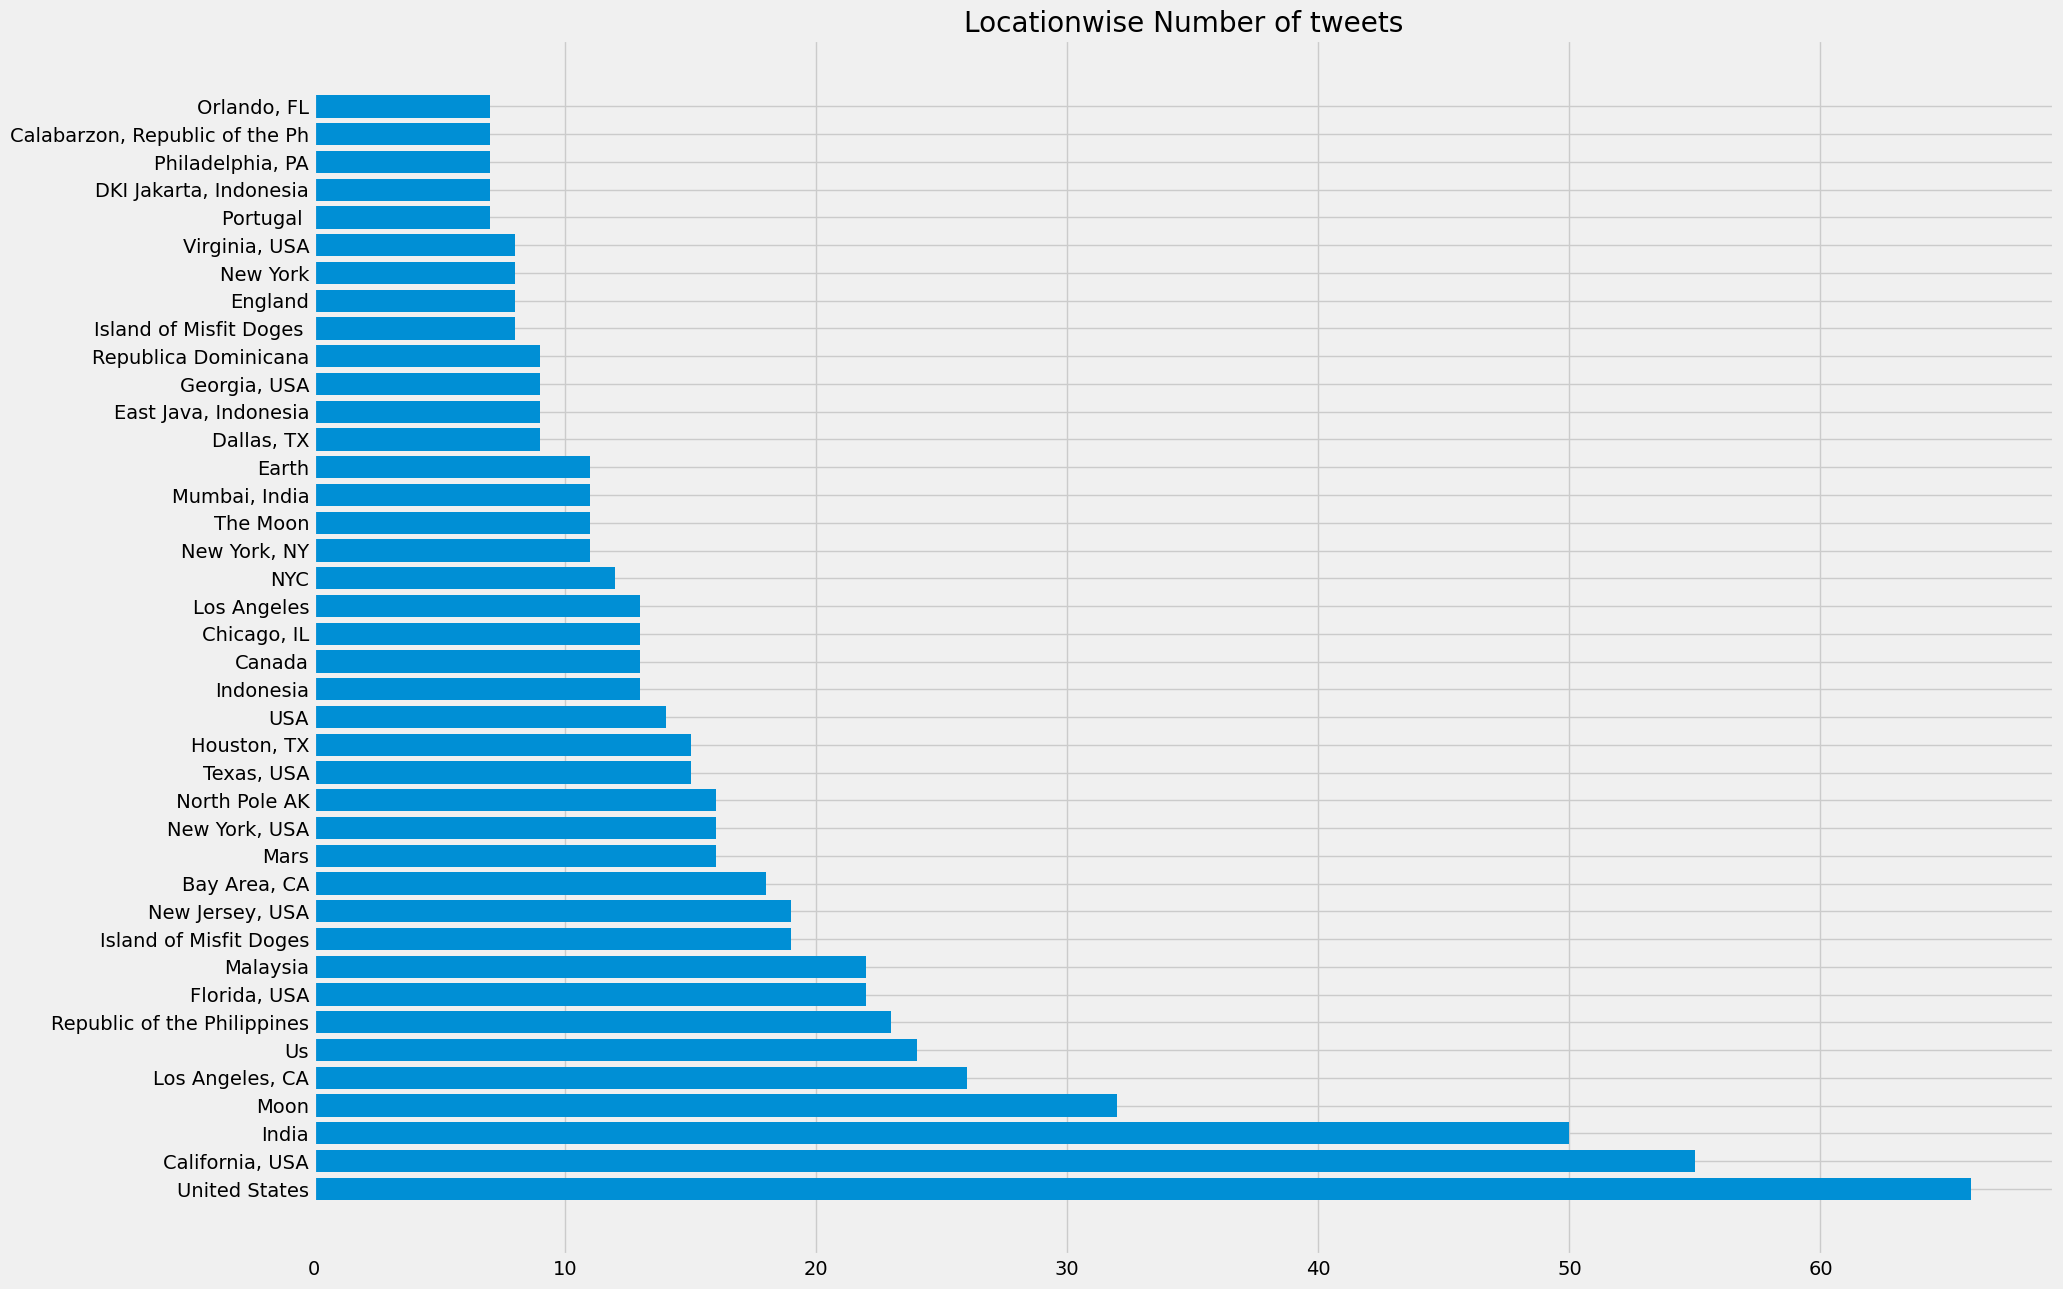

In [13]:
plt.rcdefaults()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,15))
plt.barh(lob_sorted.index[:40],lob_sorted.values[:40])
plt.title("Locationwise Number of tweets")
plt.show()

# *Tweet Text EDA*

---



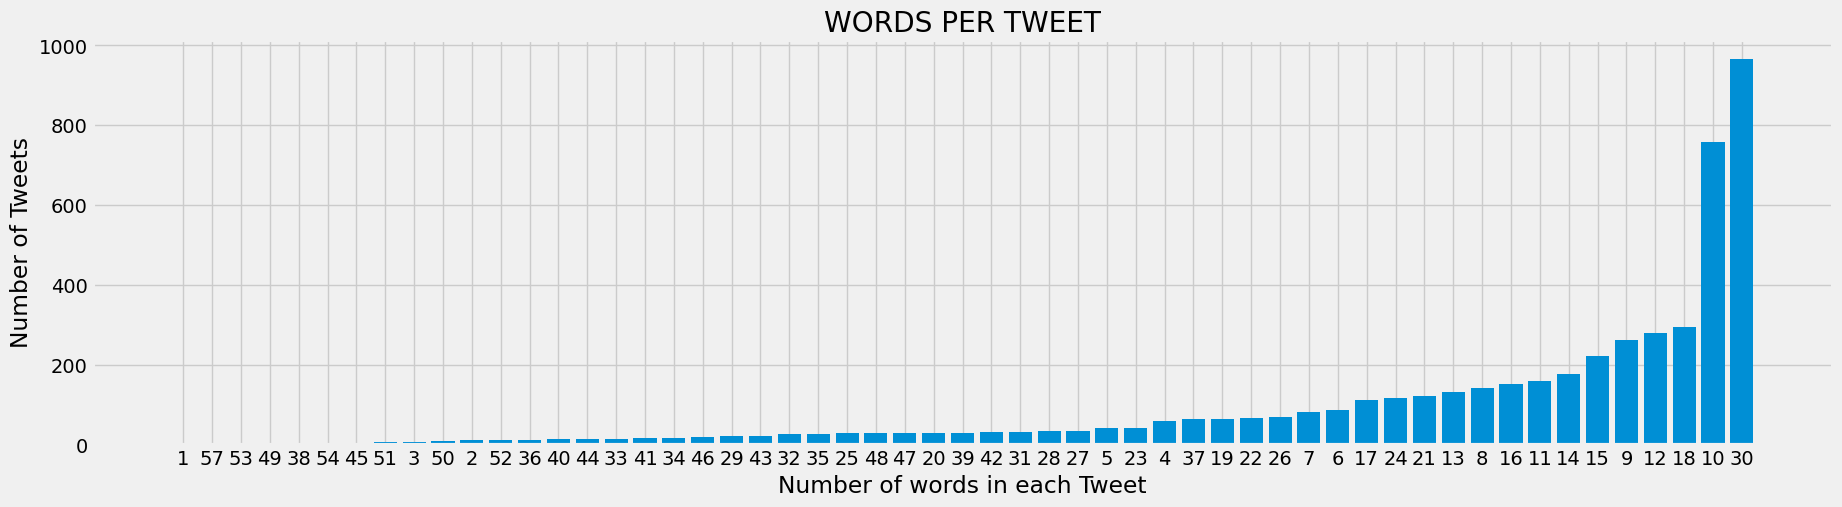

In [14]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = data['text'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Tweets')
plt.xlabel('Number of words in each Tweet')
plt.title('WORDS PER TWEET')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

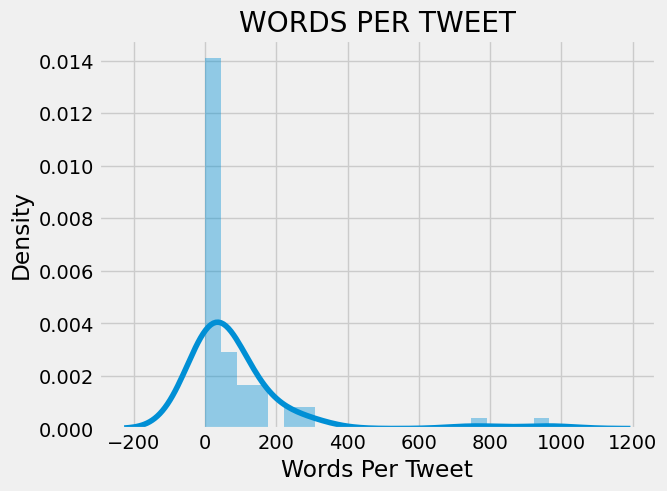

In [15]:
sns.distplot(word_count.values)
plt.title('WORDS PER TWEET')
plt.xlabel('Words Per Tweet')
plt.show()

In [16]:
tweet_text=''
for t in data['text'].values:
  tweet_text += t + ' '

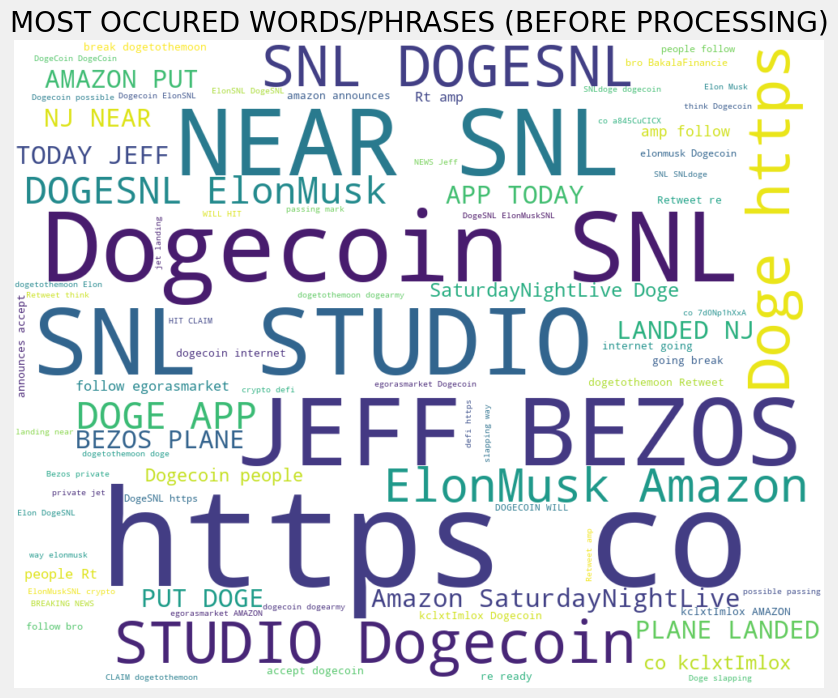

In [17]:
wordcloud = WordCloud(height=800,width=1000,min_font_size=10, background_color = 'white').generate(tweet_text)

# Display the generated image:
plt.figure(figsize = (18, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("MOST OCCURED WORDS/PHRASES (BEFORE PROCESSING)")
plt.show()

# *Hashtags EDA*

In [18]:
hashtag_count = Counter()
for idc,h in enumerate(data['hashtags']):
  hashtag_count.update(data['hashtags'][idc][1:-1].replace('\'','').replace(',',"").split(" "))

In [19]:
tags = []; vals = [];
for tag in reversed(hashtag_count.most_common(40)):
  tags.append(tag[0])
  vals.append(tag[1])

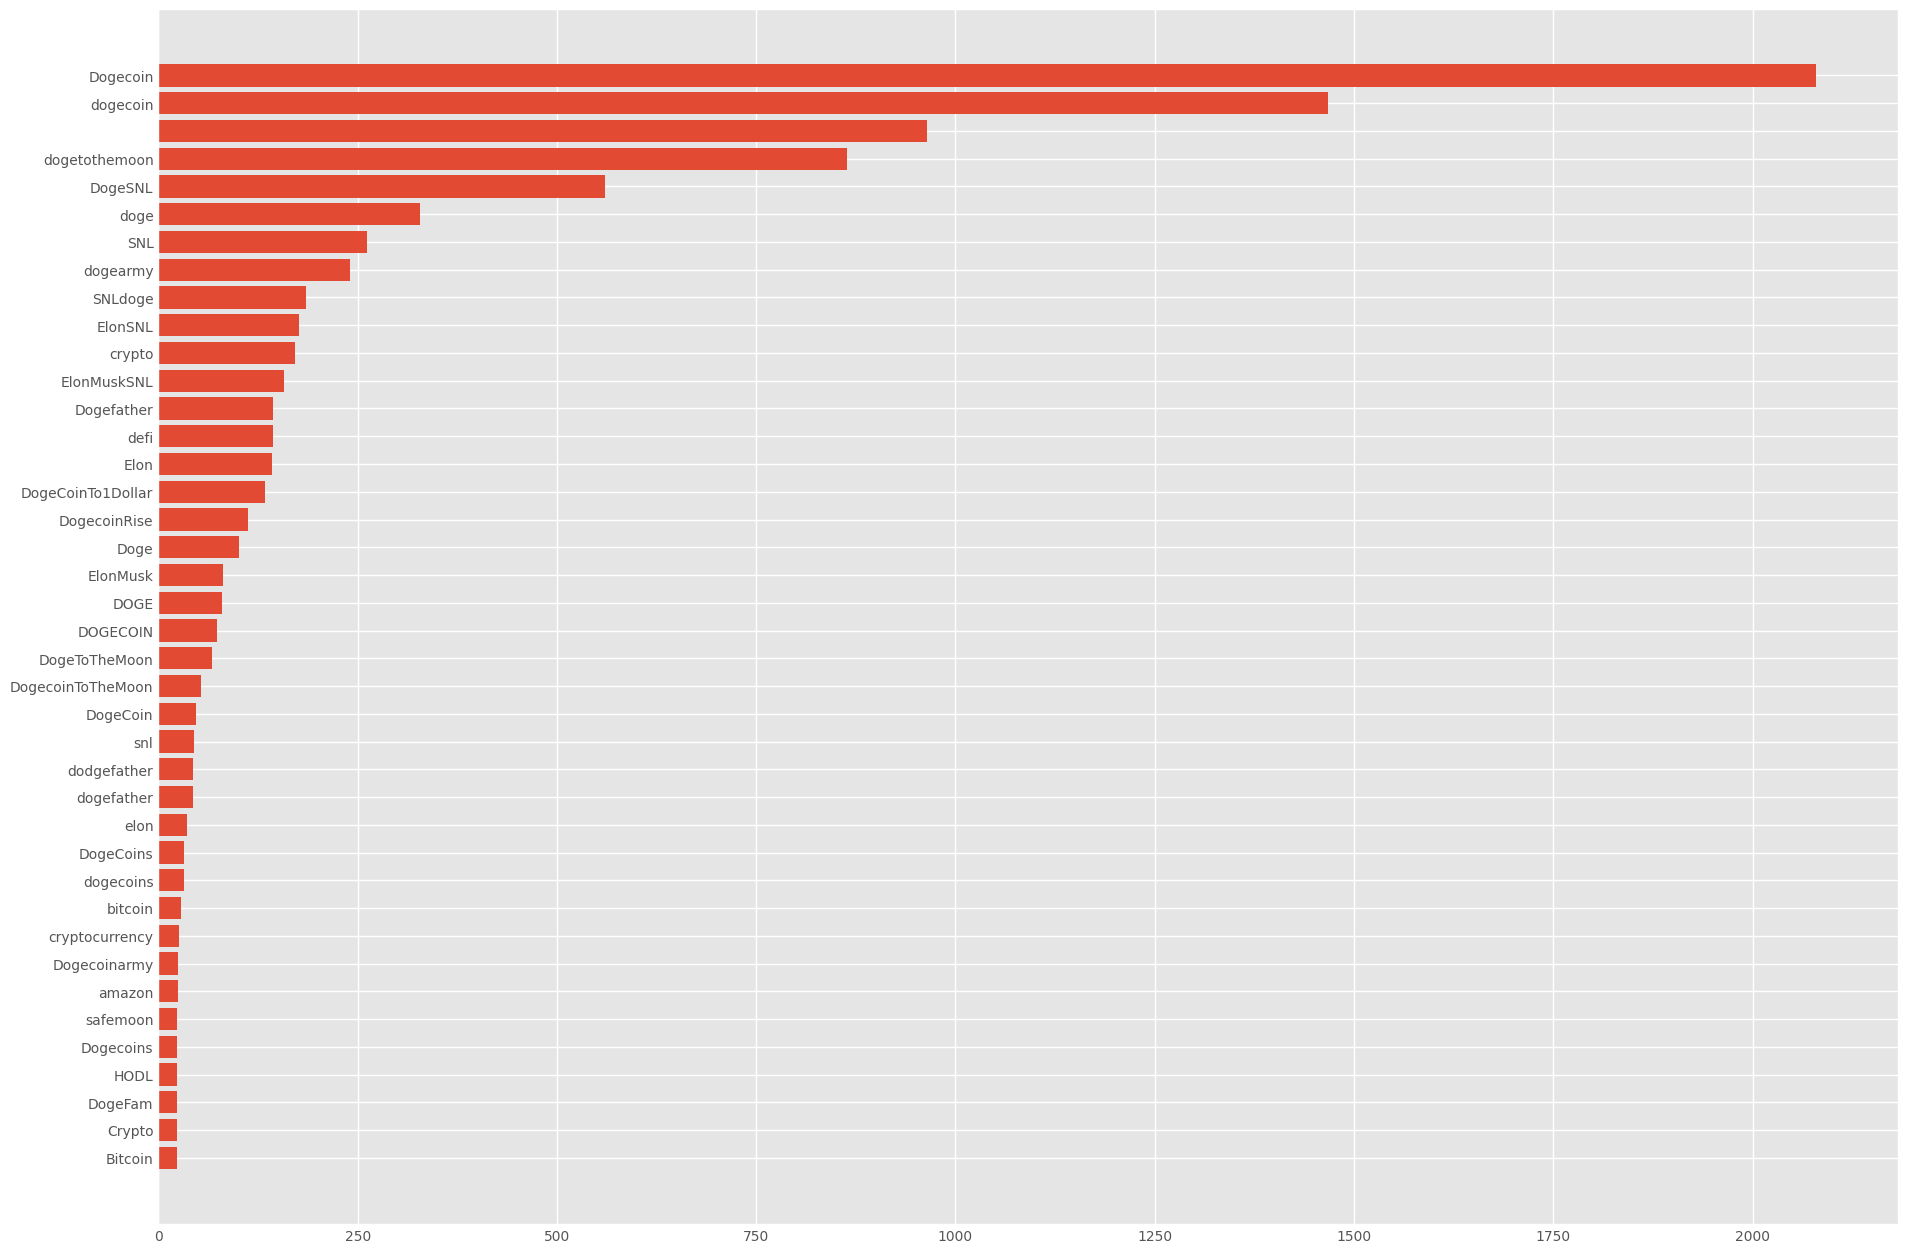

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(20,15))
plt.barh(tags,vals,)
plt.show()

# *Retweets EDA*

In [21]:
d = data.sort_values(by='retweetcount',ascending=False)
retw_c = []; retw = []
for ret,tex in zip(d['retweetcount'].values,d['text'].values):
  if ret not in retw_c and tex not in retw:
    retw_c.append(ret)
    retw.append(tex)
  if len(retw) > 20:
    break


Font 'default' does not have a glyph for '\U0001f4b0' [U+1f4b0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f4b0' [U+1f4b0], substituting with a dummy symbol.


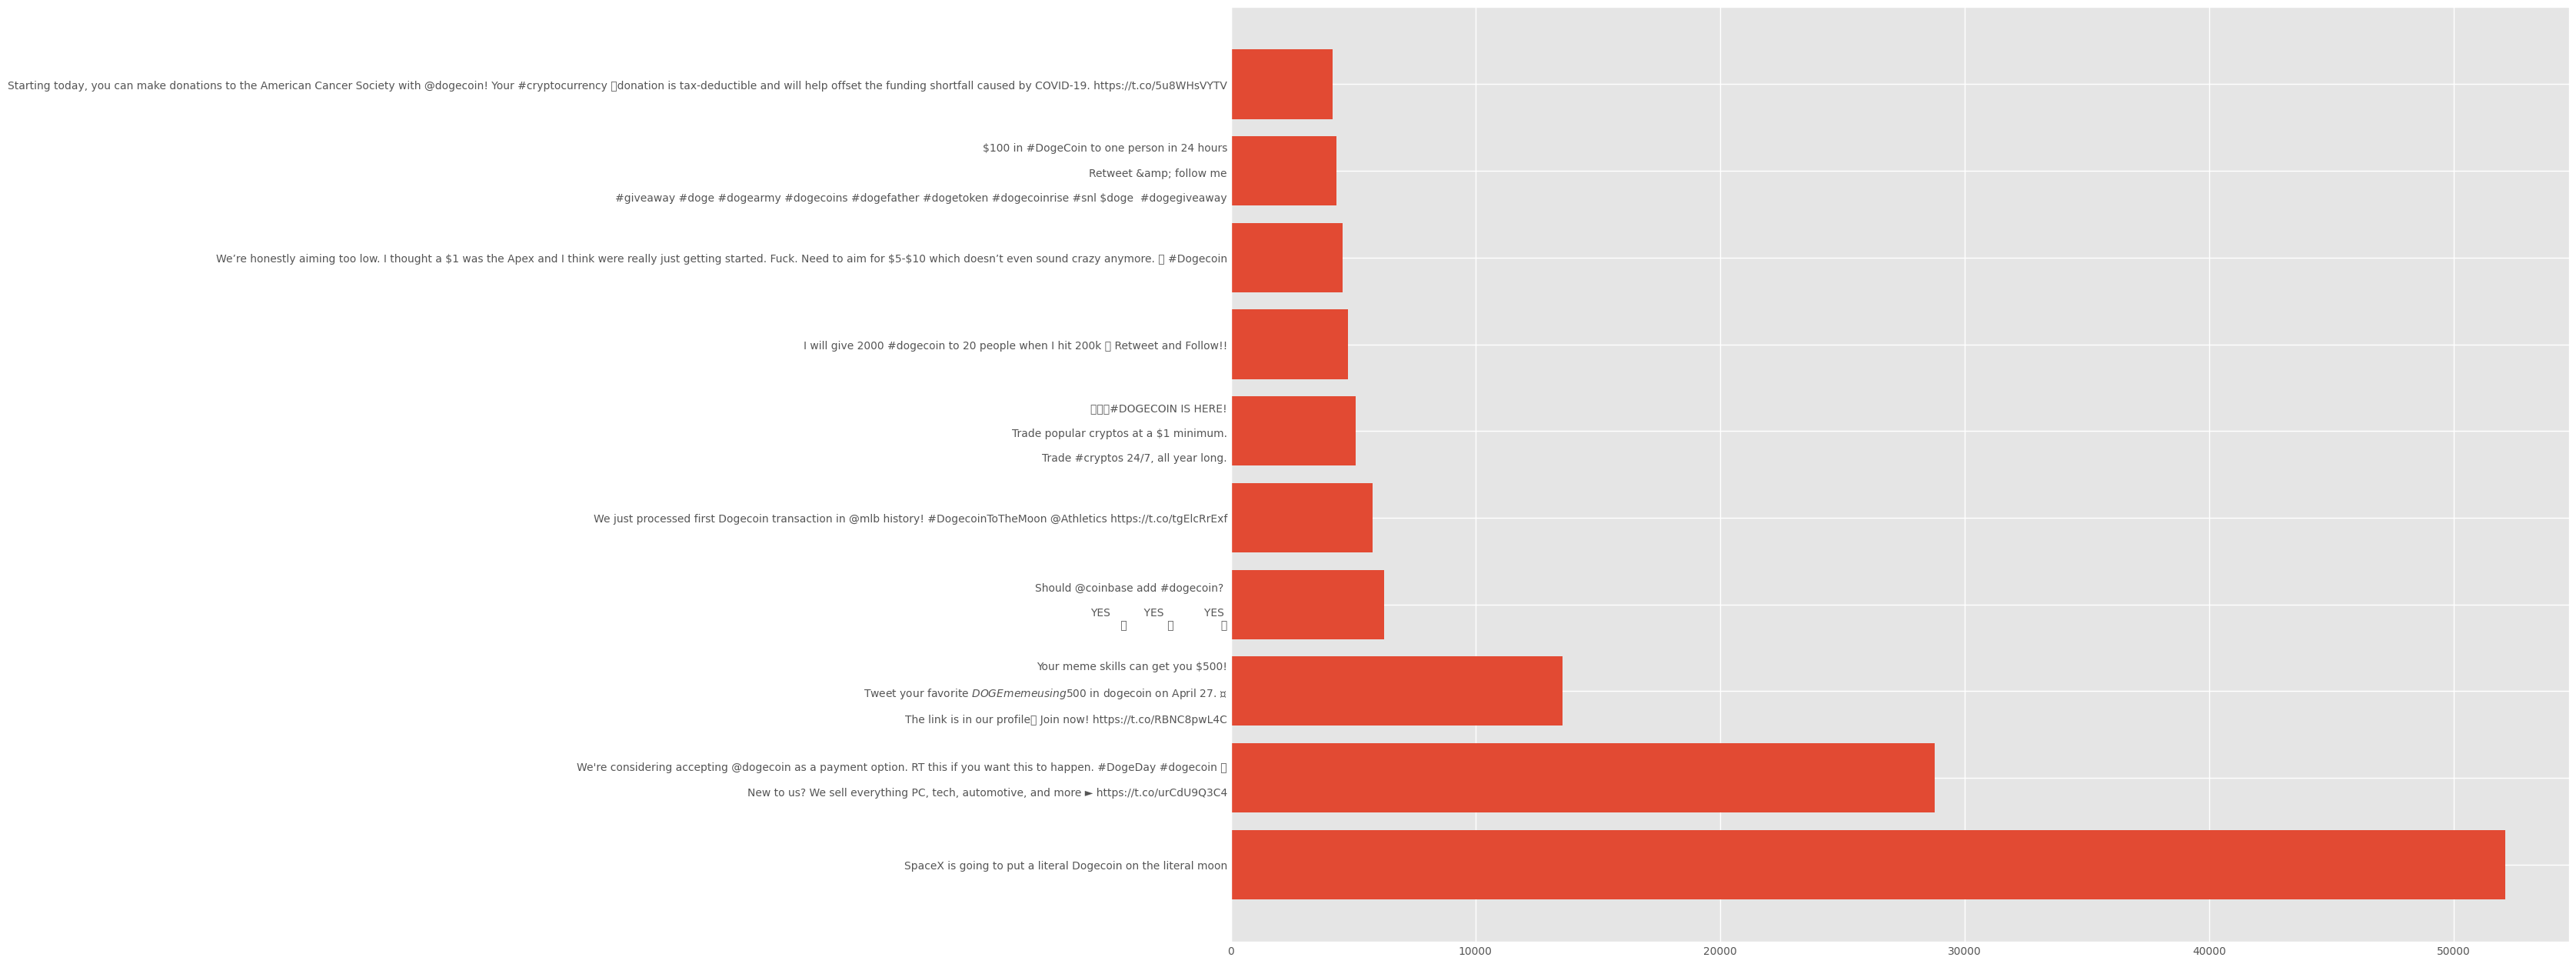

In [22]:
# plt.rcdefaults()
plt.style.use('ggplot')
plt.figure(figsize=(20,15))
plt.barh(retw[:10],retw_c[:10])
plt.show()

In [23]:
d = data.sort_values(by='retweetcount',ascending=False)
retw_c = []; retw = [] ;uzer = []
for ret,tex,u in zip(d['retweetcount'].values,d['text'].values,d['username'].values):
  if ret not in retw_c and tex not in retw:
    retw_c.append(ret)
    retw.append(tex)
    uzer.append(u)
  if len(uzer) > 20:
    break

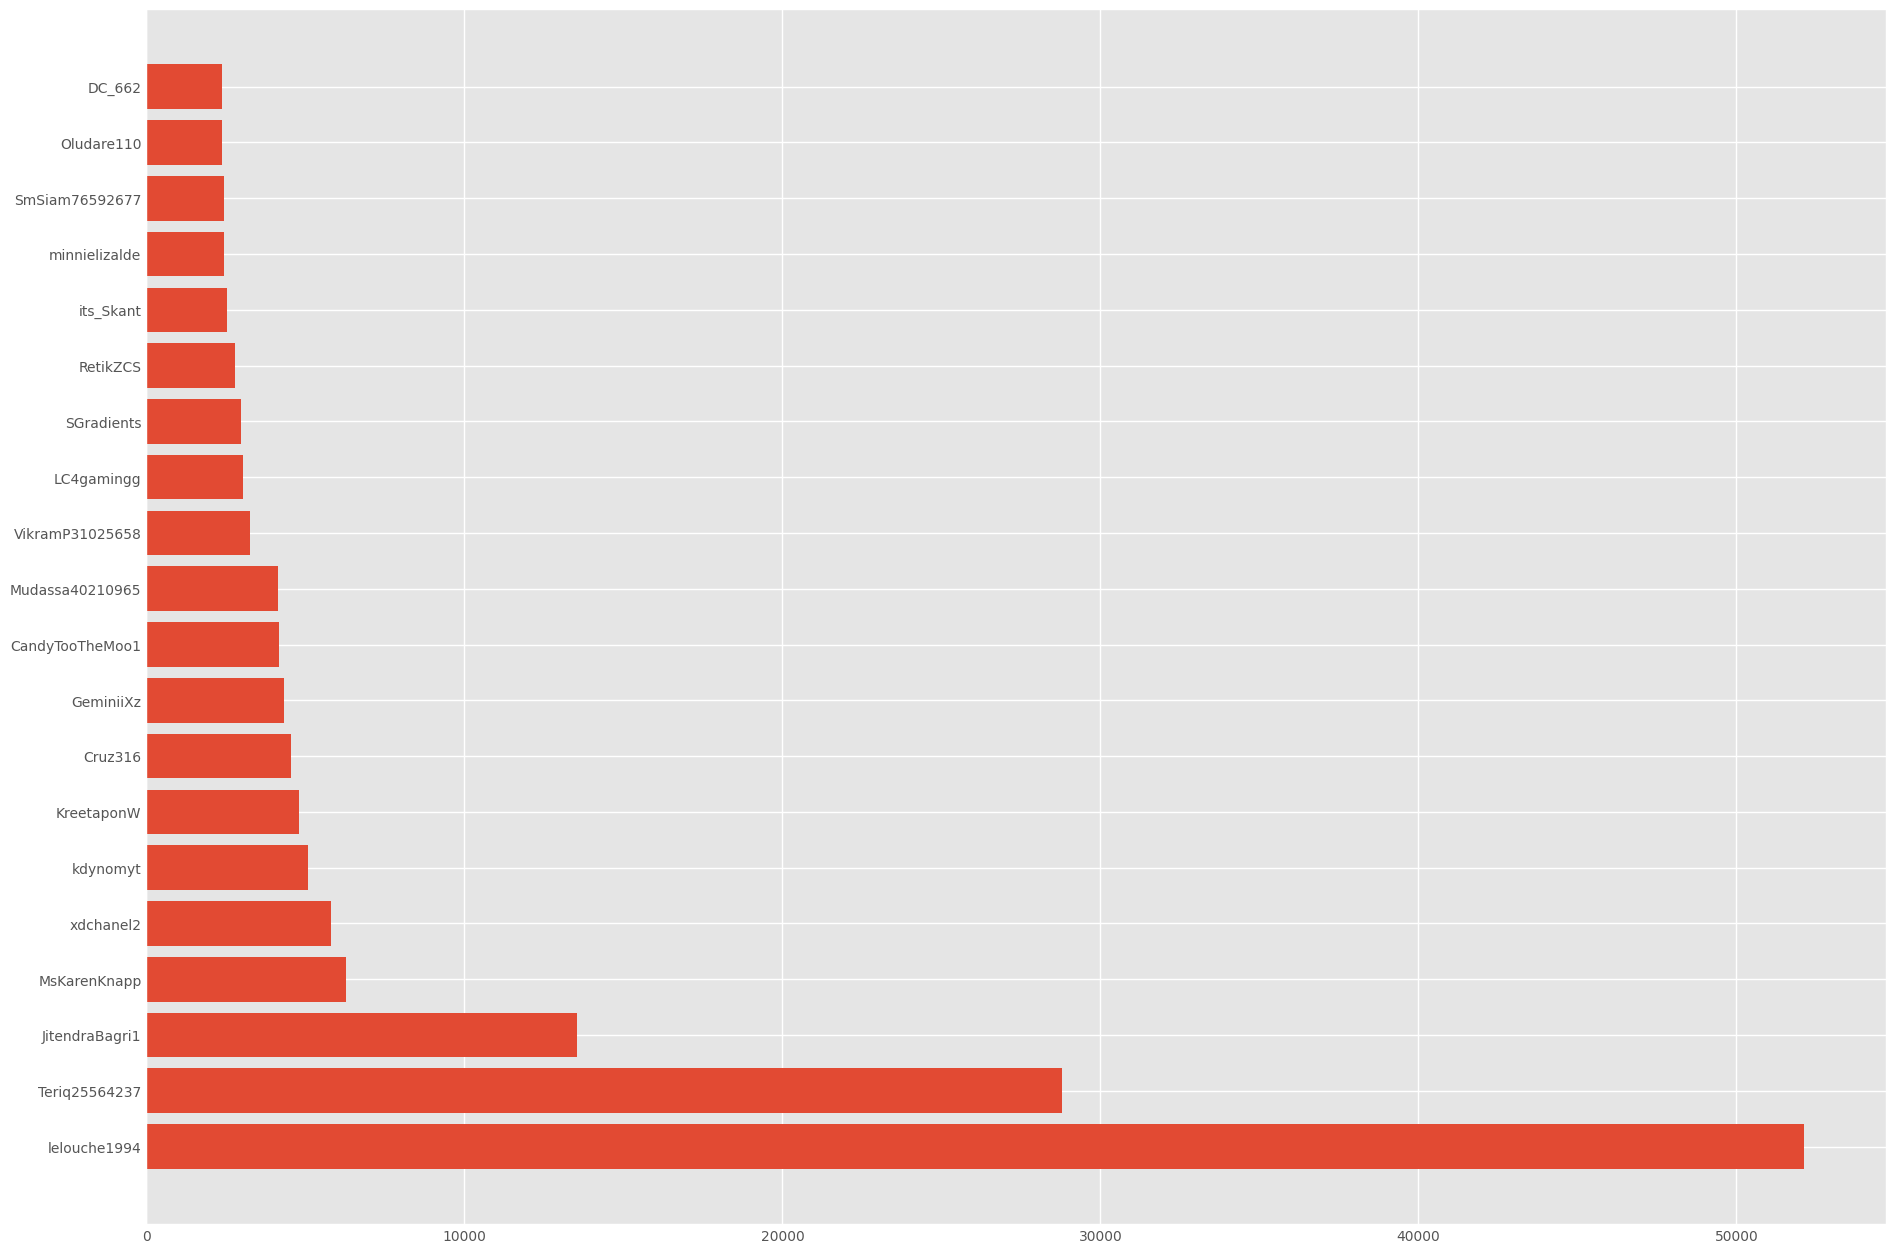

In [24]:
plt.style.use('fast')
plt.figure(figsize=(20,15))
plt.barh(uzer,retw_c)
plt.show()

# ***Basic Preprocessing***

---



# *Tweets Preprocessing*

In [25]:
print(stopwords.words('english'))
stop_words = stopwords.words('english')
def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  return " ".join(filtered_sentence)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [26]:
def cleaned(text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"!","")
    text = text.str.replace(r"!","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [27]:
demo = data['text'][:1]
print("Original Tweet : ",demo[0])
demo = cleaned(demo)
demo = remove_stopwords(demo[0])
print("Preprocessed Tweet : ",demo)

Original Tweet :  BREAKING NEWS !!!
Jeff Bezos private jet landing near SNL Studio!! #dogecoin #SNL #SNLdoge
Preprocessed Tweet :  breaking news jeff bezos private jet landing near snl studio dogecoin snl snldoge


In [28]:
data['text'] = cleaned(data['text'])
data['text'] = data['text'].apply(lambda x : remove_stopwords(x))
data['text'].head()

0    breaking news jeff bezos private jet landing n...
1    amazon announces accept dogecoin internet goin...
2    amazon put doge app today also jeff bezos plan...
3    drill go big things works everyone dogetothemo...
4    rt follow drop dogecoin address dogetothemoon ...
Name: text, dtype: object

In [29]:
data.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,emadelia2,NaN,NaN,1928,154,1018,330,breaking news jeff bezos private jet landing n...,"['dogecoin', 'SNL', 'SNLdoge']"
1,NIKERED7,SPR7,"Manhattan, NY",9,109,7440,273,amazon announces accept dogecoin internet goin...,"['dogecoin', 'dogetothemoon']"
2,marsudianton,Marketers,Balikpapan_indonesia,436,180,1932,1792,amazon put doge app today also jeff bezos plan...,['Dogecoin']
3,SaulCha02766278,NaN,NaN,12,15,47,1,drill go big things works everyone dogetothemo...,"['dogetothemoon', 'doge', 'dogecoin', 'DogeSNL..."
4,khonamiee,NaN,NaN,37,19,81,1418,rt follow drop dogecoin address dogetothemoon ...,"['dogecoin', 'dogetothemoon', 'dogearmy', 'Dog..."


# *Feature Extraction*

In [30]:
def getSentiment(data):
  ob = SentimentIntensityAnalyzer()
  scores=np.zeros(shape=(len(data),4))

  for e,essay in tqdm(enumerate(data)):
    score = ob.polarity_scores(essay)
    scores[e][0]=score['neg']
    scores[e][1]=score['neu']
    scores[e][2]=score['pos']
    scores[e][3]=score['compound']

  return scores


In [31]:
sentiments = pd.DataFrame(data = getSentiment(data['text']),columns = ['neg','neu','pos','comp'])
print(sentiments.shape)
sentiments.head()

5000it [00:01, 4849.44it/s]

(5000, 4)


,neg,neu,pos,comp
0,0.000,1.000,0.000,0.0000
1,0.000,0.507,0.493,0.7003
2,0.000,0.855,0.145,0.3400
3,0.000,0.884,0.116,0.1779
4,0.208,0.792,0.000,-0.2732


In [32]:
data=pd.concat([data,sentiments],axis=1)
data.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,neg,neu,pos,comp
0,emadelia2,NaN,NaN,1928,154,1018,330,breaking news jeff bezos private jet landing n...,"['dogecoin', 'SNL', 'SNLdoge']",0.000,1.000,0.000,0.0000
1,NIKERED7,SPR7,"Manhattan, NY",9,109,7440,273,amazon announces accept dogecoin internet goin...,"['dogecoin', 'dogetothemoon']",0.000,0.507,0.493,0.7003
2,marsudianton,Marketers,Balikpapan_indonesia,436,180,1932,1792,amazon put doge app today also jeff bezos plan...,['Dogecoin'],0.000,0.855,0.145,0.3400
3,SaulCha02766278,NaN,NaN,12,15,47,1,drill go big things works everyone dogetothemo...,"['dogetothemoon', 'doge', 'dogecoin', 'DogeSNL...",0.000,0.884,0.116,0.1779
4,khonamiee,NaN,NaN,37,19,81,1418,rt follow drop dogecoin address dogetothemoon ...,"['dogecoin', 'dogetothemoon', 'dogearmy', 'Dog...",0.208,0.792,0.000,-0.2732


# ***Sentiment Analysis***

---



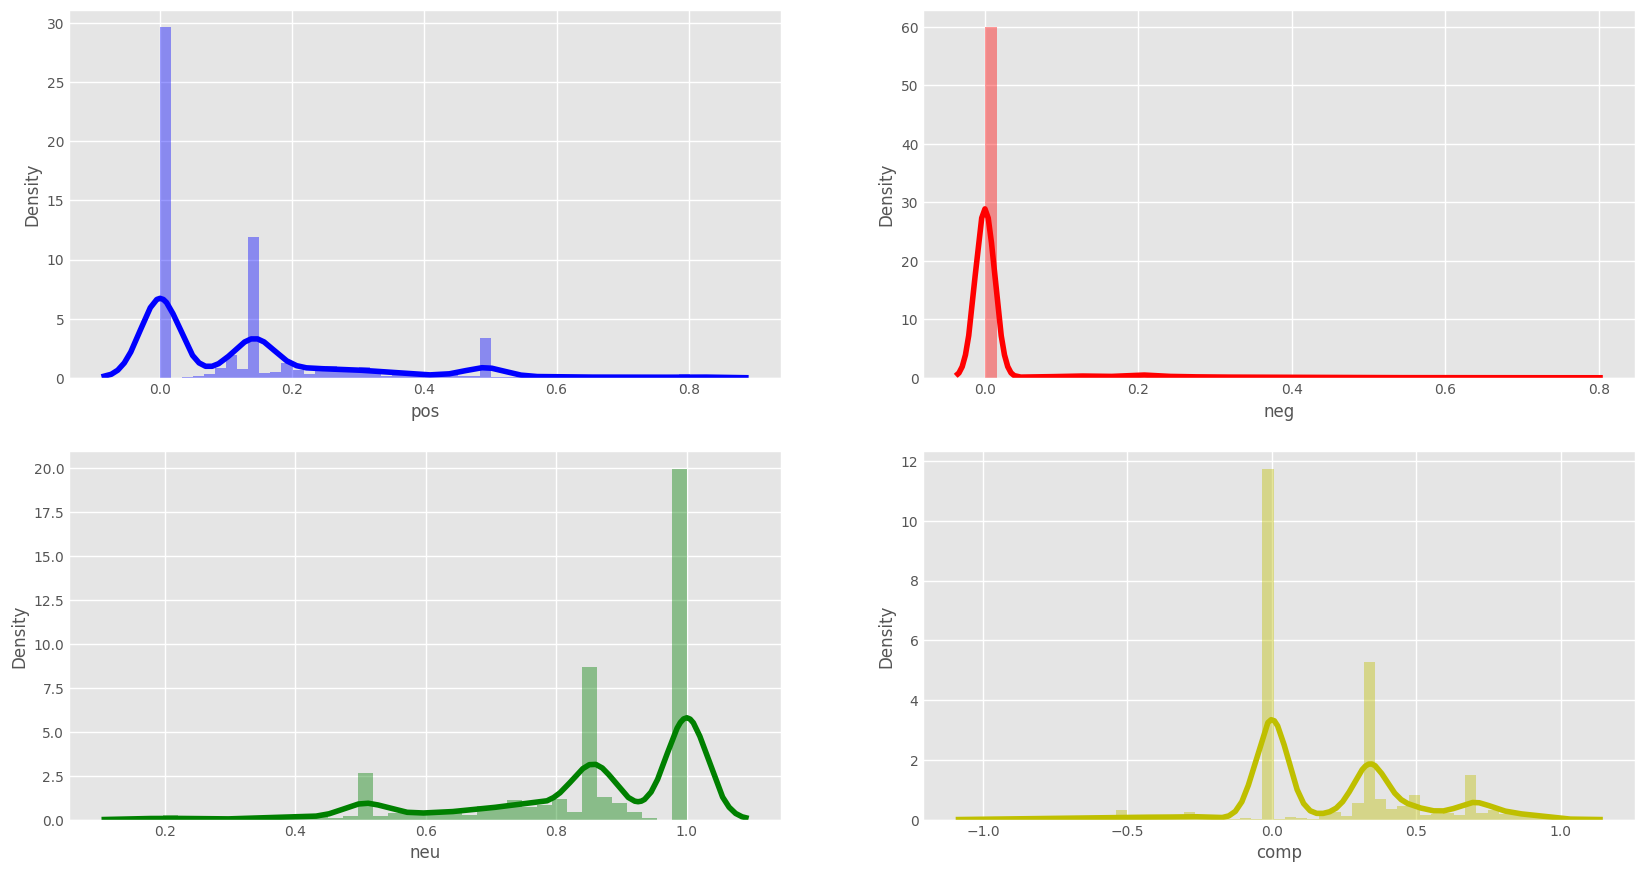

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.distplot(ax=axes[0, 0], a=data['pos'],color='b')
sns.distplot(ax=axes[0, 1], a=data['neg'],color='r')
sns.distplot(ax=axes[1, 0], a=data['neu'],color='g')
sns.distplot(ax=axes[1, 1], a=data['comp'],color='y')

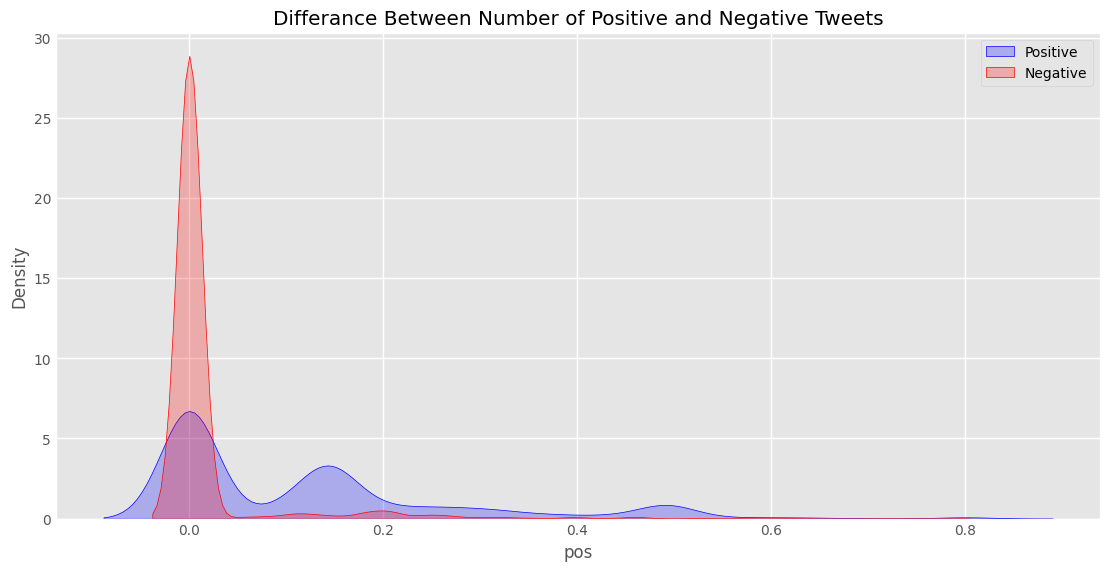

In [34]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(data['pos'], shade=True, color="b").set_title('Differance Between Number of Positive and Negative Tweets')
p2=sns.kdeplot(data['neg'], shade=True, color="r")
plt.legend(labels=['Positive','Negative'])

Text(0.5, 1.0, 'NEGATIVE vs NEUTRAL vs POSITIVE')

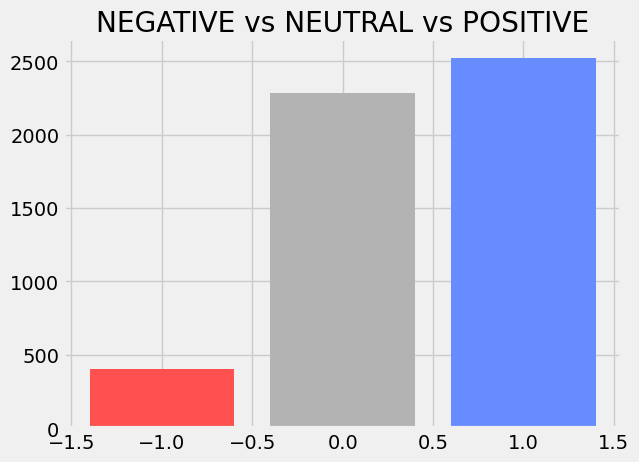

In [35]:
pos_filt = data['pos'] > 0
neg_filt = data['neg'] > 0
neu_filt = data['neu'] == 1

# plt.xkcd(scale=0.3, length=100)
plt.rcdefaults()
plt.style.use('fivethirtyeight')
plt.bar([1,0,-1],[data[pos_filt].shape[0],data[neu_filt].shape[0],data[neg_filt].shape[0]],color=['#668cff','#b3b3b3','#ff5050'])
plt.title("NEGATIVE vs NEUTRAL vs POSITIVE")

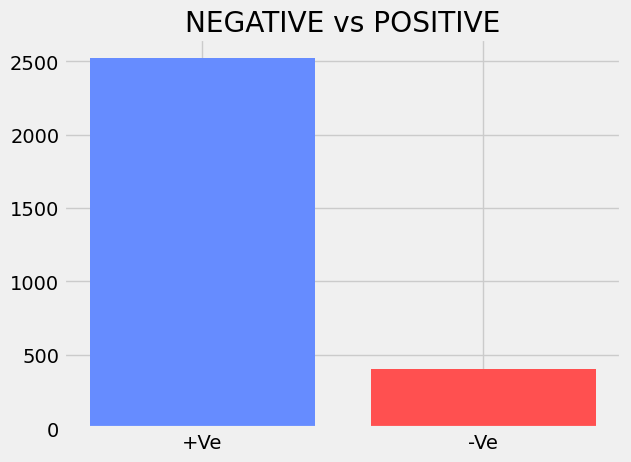

In [36]:
plt.bar(['+Ve','-Ve'],[data[pos_filt].shape[0],data[neg_filt].shape[0]],color=['#668cff','#ff5050'])
plt.title("NEGATIVE vs POSITIVE")
plt.show()
plt.rcdefaults()

TOP POSITIVE TWEETS

In [37]:
d = data.sort_values(by='pos',ascending=False)
sent_score = []; twit = []
for sent,tex in zip(d['pos'].values,d['text'].values):
  if tex not in twit:
    sent_score.append(sent)
    twit.append(tex)
  if len(twit) > 30:
    break
print("TOP 10 POSITIVE TWEETS : \n")
for t in twit[:10]:
  print(t)

TOP 10 POSITIVE TWEETS : 

500 dogecoin ? yes yes yes
500 dogecoin yes yes yes
amazon x dogecoin huge
dogecoin rescue
love dogecoin nearly ready see amazing entertainment elonmusk nbcsnl enjoy show
coinbase add dogecoin ? yes yes yes
dogecoin better start playing dreams nightmares
dogecoin love sprinkled hopes dreams around world
dogecoin biggest allocation portfolio ? yes yes yes
watching snl tonight dogecoin yes yes yes


Text(0.5, 1.0, 'TOP WORDS IN TOP POSITIVE TWEETS')

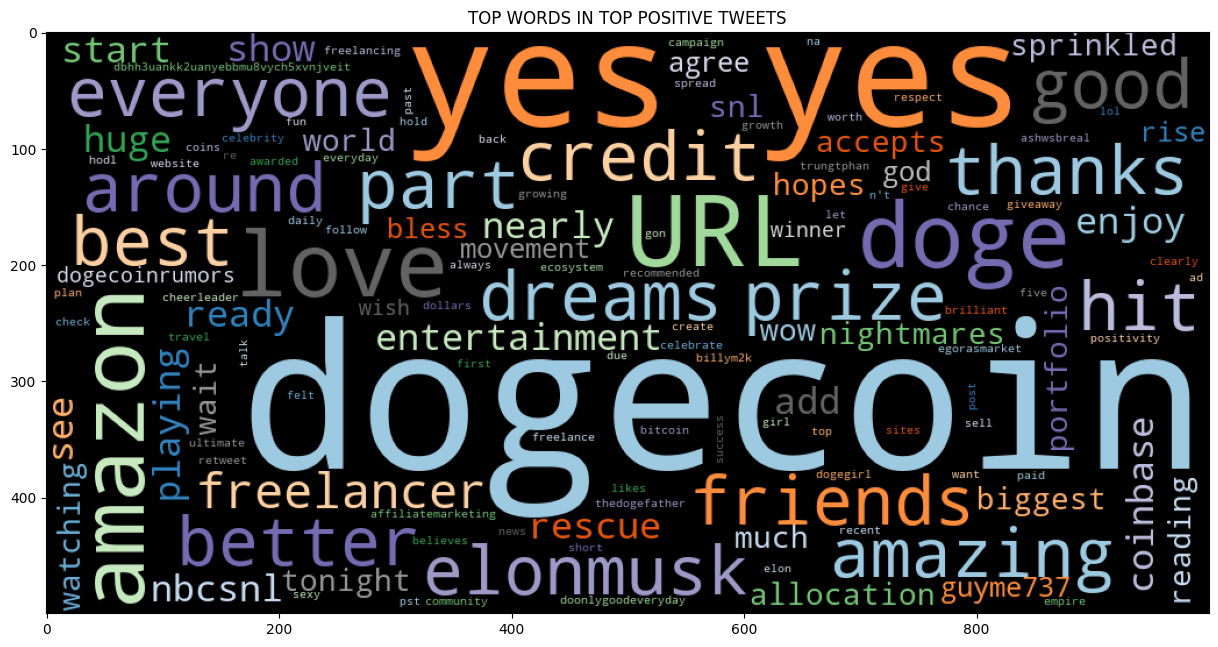

In [38]:
plt.style.use('ggplot')
plt.rcdefaults()
unique_string=(" ").join(twit)
wordcloud = WordCloud(width = 1000, height = 500, colormap='tab20c').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title('TOP WORDS IN TOP POSITIVE TWEETS')

TOP NEGATIVE TWEETS

In [39]:
d = data.sort_values(by='neg',ascending=False)
sent_score = []; twit = []
for sent,tex in zip(d['neg'].values,d['text'].values):
  if tex not in twit:
    sent_score.append(sent)
    twit.append(tex)
  if len(twit) > 30:
    break
print("TOP 10 NEGATIVE TWEETS : \n")
for t in twit[:10]:
  print(t)

TOP 10 NEGATIVE TWEETS : 

panic dogecoin
idk niggas make dogecoin lower whatever stop
elonmusk scam URL dogecoin scam
panic sell dogecoin
fuckers selling dogecoin blow
nasty bitches tryna use dogecoin clout followers lollllol
feel douchebag investing dogecoin ? want ass licked sumn ?
people talking snl dogecoin worrying damn rocket china supposed crash
panic hodl hodling ? dogecoin
elon make dogecoin rise tonight im beating crackas ass


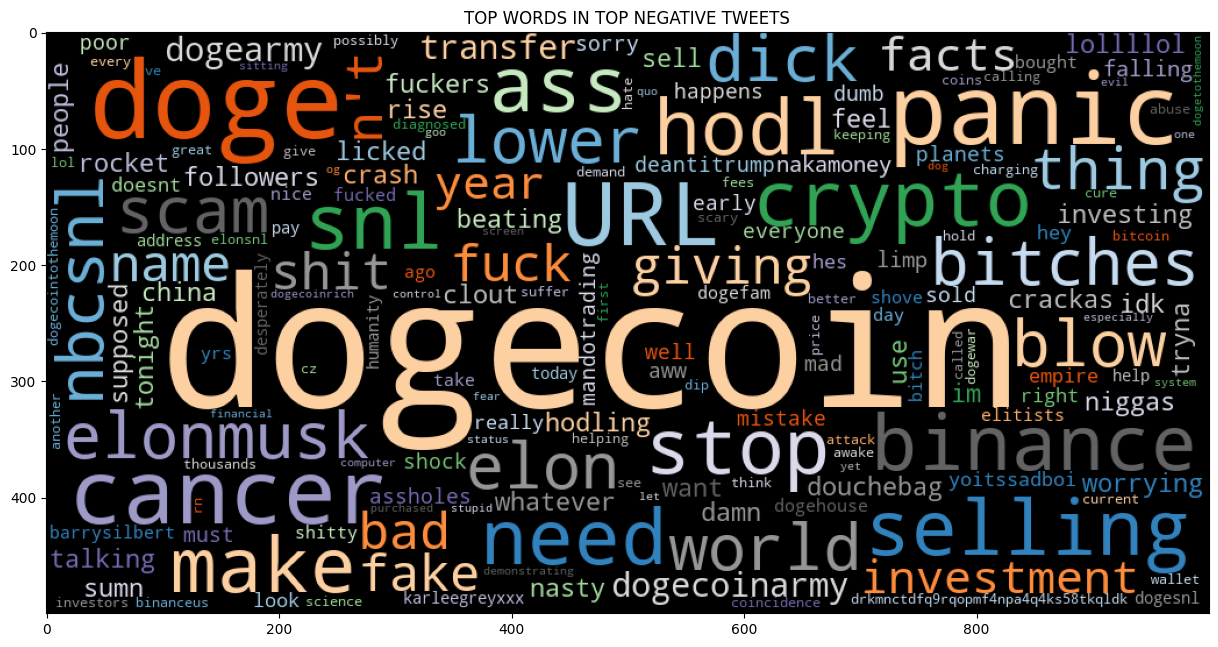

In [40]:
unique_string=(" ").join(twit)
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab20c').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title('TOP WORDS IN TOP NEGATIVE TWEETS')
plt.show()
plt.close()

# ***Modeling***

---



# *Creating Data*

---



In [41]:
new_data = data[['text','neg','pos','neu','comp']]
new_data.head()

,text,neg,pos,neu,comp
0,breaking news jeff bezos private jet landing n...,0.000,0.000,1.000,0.0000
1,amazon announces accept dogecoin internet goin...,0.000,0.493,0.507,0.7003
2,amazon put doge app today also jeff bezos plan...,0.000,0.145,0.855,0.3400
3,drill go big things works everyone dogetothemo...,0.000,0.116,0.884,0.1779
4,rt follow drop dogecoin address dogetothemoon ...,0.208,0.000,0.792,-0.2732


Labeling Data

In [42]:
new_data['polarity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
new_data['target']  = 0
new_data['target'][new_data['polarity'] > 0] = 1
new_data['target'][new_data['polarity'] <= 0] = -1
new_data.drop(['polarity'],axis=1,inplace=True)

In [43]:
new_data.head()

,text,neg,pos,neu,comp,target
0,breaking news jeff bezos private jet landing n...,0.000,0.000,1.000,0.0000,1
1,amazon announces accept dogecoin internet goin...,0.000,0.493,0.507,0.7003,1
2,amazon put doge app today also jeff bezos plan...,0.000,0.145,0.855,0.3400,1
3,drill go big things works everyone dogetothemo...,0.000,0.116,0.884,0.1779,-1
4,rt follow drop dogecoin address dogetothemoon ...,0.208,0.000,0.792,-0.2732,-1


In [44]:
vect = TfidfVectorizer(ngram_range=(1,2),max_features=500)
vect.fit(new_data['text'])

transformed = vect.transform(new_data['text'])
transformed.shape

(5000, 500)

In [45]:
cols = ['f_'+str(i) for i in range(500)]
print(cols[5])

f_5


In [46]:
f_data = pd.DataFrame.sparse.from_spmatrix(transformed,columns=cols)
np.count_nonzero(f_data)

91236

In [47]:
final = pd.concat([new_data.drop(['text'],axis=1),f_data],axis=1)
final.head()

,neg,pos,neu,comp,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,...,f_460,f_461,f_462,f_463,f_464,f_465,f_466,f_467,f_468,f_469,f_470,f_471,f_472,f_473,f_474,f_475,f_476,f_477,f_478,f_479,f_480,f_481,f_482,f_483,f_484,f_485,f_486,f_487,f_488,f_489,f_490,f_491,f_492,f_493,f_494,f_495,f_496,f_497,f_498,f_499
0,0.000,0.000,1.000,0.0000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0.493,0.507,0.7003,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.145,0.855,0.3400,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14789,0.154928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0.116,0.884,0.1779,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.208,0.000,0.792,-0.2732,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X = final.drop(['target'],axis=1)
y = final['target']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# *Applying Logistic Regression Classifier*

---



In [50]:
LR = LogisticRegression()

param = {'C':[0.001,0.01,0.1,1,10,100],'penalty':['l1','l2']}

gridClf = GridSearchCV(LR,param_grid=param,scoring='roc_auc',cv=3,verbose=2)

gridClf.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.001, penalty=l1, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.001, penalty=l1, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................
[CV] .............................. C=0.001, penalty=l1, total=   0.2s
[CV] C=0.001, penalty=l2 .............................................
[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   11.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [51]:
gridClf.best_params_

{'C': 10, 'penalty': 'l2'}

In [52]:
best_LR_model = LogisticRegression(penalty='l2',C=10)

best_LR_model.fit(X_train,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
LR_predicted_train = best_LR_model.predict(X_train)
LR_predicted_test = best_LR_model.predict(X_test)

In [54]:
LR_train_acc = accuracy_score(y_train,LR_predicted_train)
LR_test_acc = accuracy_score(y_test,LR_predicted_test)

print("Training Accuracy : ",LR_train_acc)
print("Testing Accuracy : ",LR_test_acc)

Training Accuracy :  0.9762666666666666
Testing Accuracy :  0.964


Logistic Regression F1-Score :  0.9571020019065777 



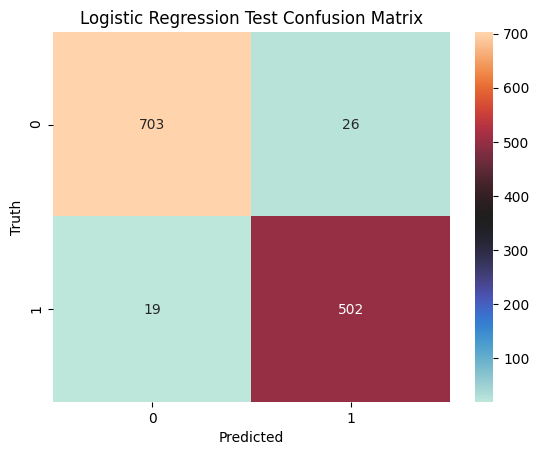

In [55]:
sns.heatmap(confusion_matrix(y_test,LR_predicted_test),annot=True,fmt=".5g",cmap='icefire')
plt.title("Logistic Regression Test Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Truth')

LR_f1 = f1_score(y_test,LR_predicted_test)

print("Logistic Regression F1-Score : ",LR_f1,"\n")

# *Applying Multinomial Naive Bayes*

In [56]:
X_train_MNB = X_train.drop(['comp'],axis=1)
X_test_MNB = X_test.drop(['comp'],axis=1)

In [57]:
MNB = MultinomialNB()

param_MNB = {'alpha':[0.001,0.01,0.1,1,10,100]}

gridClf_MNB = GridSearchCV(MNB,param_grid=param_MNB,scoring='roc_auc',cv=3,verbose=2)

gridClf_MNB.fit(X_train_MNB,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.4s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [58]:
gridClf_MNB.best_params_

{'alpha': 0.001}

In [59]:
best_MNB_model = MultinomialNB(alpha=0.001)

best_MNB_model.fit(X_train_MNB,y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [60]:
MNB_predicted_train = best_MNB_model.predict(X_train_MNB)
MNB_predicted_test = best_MNB_model.predict(X_test_MNB)

In [61]:
MNB_train_acc = accuracy_score(y_train,MNB_predicted_train)
MNB_test_acc = accuracy_score(y_test,MNB_predicted_test)

print("Training Accuracy : ",MNB_train_acc)
print("Testing Accuracy : ",MNB_test_acc)

Training Accuracy :  0.9256
Testing Accuracy :  0.9312


Multinomial Naive Bayes F1-score :  0.9146825396825395


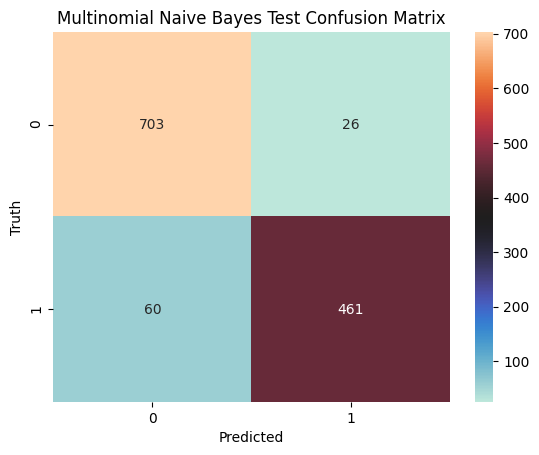

In [62]:
sns.heatmap(confusion_matrix(y_test,MNB_predicted_test),annot=True,fmt=".5g",cmap='icefire')
plt.title("Multinomial Naive Bayes Test Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Truth')

MNB_f1 = f1_score(y_test,MNB_predicted_test)

print("Multinomial Naive Bayes F1-score : ",MNB_f1)

In [63]:
from prettytable import PrettyTable
PTables = PrettyTable()

PTables = PrettyTable()
PTables.field_names = ["MODEL.","F1-Score", "Train-Accuracy","Test-Accuracy"]
PTables.add_row(["Logistic Regression",LR_f1, LR_train_acc,LR_test_acc])
PTables.add_row(["Naive Bayes",MNB_f1, MNB_train_acc,MNB_test_acc])

# ***`Summarizing Results`***

In [64]:
print(PTables)

+---------------------+--------------------+--------------------+---------------+
|        MODEL.       |      F1-Score      |   Train-Accuracy   | Test-Accuracy |
+---------------------+--------------------+--------------------+---------------+
| Logistic Regression | 0.9571020019065777 | 0.9762666666666666 |     0.964     |
|     Naive Bayes     | 0.9146825396825395 |       0.9256       |     0.9312    |
+---------------------+--------------------+--------------------+---------------+


# *Unsupervised Learning*

In [111]:
X_u = final.drop(['target'],axis=1)
y_u = final['target']
X_train_unsup, X_test_unsup, y_train_unsup, y_test_unsup = train_test_split(X_u, y_u, test_size=0.25, random_state=42)

In [112]:
from sklearn.cluster import KMeans

# X_train_unsup = X_train_unsup.drop(['pos','neg','neu','comp'],axis = 1)
# X_test_unsup = X_test_unsup.drop(['pos','neg','neu','comp'],axis = 1)

In [113]:
KMean = KMeans(n_clusters = 2)

KMean.fit(X_train_unsup)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [114]:
test_final_predicted = KMean.predict(X_test_unsup)
print(test_final_predicted)
def r(a):
  if a == 0:
    return -1
  return 1
print()
accuracy_score([r(x) for x in test_final_predicted],y_test)

[0 0 0 ... 1 1 0]



0.7784